# Gaussian-process linear inversion demo
In the case where both the likelihood and prior distributions are multivariate
normal, and the forward-model is linear, the posterior distribution is also
multivariate normal, and the posterior mean and covariance can be calculated
directly from the likelihood and prior mean and covariance.

If each of the model parameters can be associated with a position in some
space (which is often the case in tomography and deconvolution problems)
and we expect their values to be correlated within that space, we can
model this behavior using a gaussian-process prior distribution.

This 'gaussian-process linear inversion' technique is implemented as the `GpLinearInverter` class.

In [1]:
import matplotlib.pyplot as plt
from numpy import array, diagonal, linspace, sqrt, zeros
from numpy.random import normal
from scipy.special import erfc
from scipy.linalg import solve

To demonstrate the use of `GpLinearInverter`, we first set up a toy deconvolution problem, starting by defining the solution we will attempt to reconstruct:

In [2]:
def lorentzian(x, A, w, c):
    z = (x - c) / w
    return A / (1 + z**2)

n_data, n_basis = 32, 64
x = linspace(-1, 1, n_basis)
data_axis = linspace(-1, 1, n_data)
solution = lorentzian(x, 1.,   0.1,  0.)
solution += lorentzian(x, 0.8,  0.15, 0.3)
solution += lorentzian(x, 0.3,  0.1, -0.45)

Now we construct a linear forward-model which will apply a gaussian convolution to the solution:

In [3]:
def normal_cdf(x, mu=0., sigma=1.):
    z = -(x - mu) / (sqrt(2) * sigma)
    return 0.5 * erfc(z)

# 'A' matrix is our linear forward model
A = zeros([n_data, n_basis])
blur_width = 0.08
dx = 0.5*(x[1] - x[0])
for k in range(n_basis):
    A[:, k] = normal_cdf(data_axis+dx, mu=x[k], sigma=blur_width)
    A[:, k] -= normal_cdf(data_axis-dx, mu=x[k], sigma=blur_width)

The matrix-vector product of the model matrix `A` and the solution vector yields a prediction of the measured data, to which we add some noise:

In [4]:
noise_sigma = 0.02
y = A @ solution + normal(size=n_data, scale=noise_sigma)
y_err = zeros(n_data) + noise_sigma

We can plot the solution and the forward-model prediction together to see the effect of the convolution:

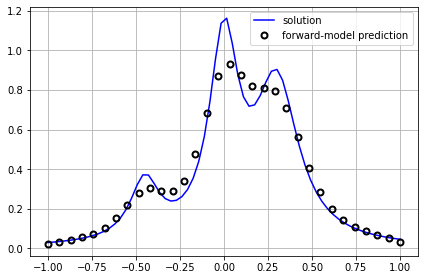

In [5]:
plt.plot(x, solution, color="blue", label="solution")
plt.plot(data_axis, A @ solution, marker="o", color="black", markerfacecolor="none", 
         markeredgewidth=2, ls="none", label="forward-model prediction")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Our objective is to infer the values in `solution` using only the synthetic data `y` and the measurement errors `y_err`.

To calculate the posterior for the solution values, we need to specify models for the prior mean and covariance. For the mean we'll use a spatially-constant mean function, implemented as `ConstantMean`.

For the prior covariance, we will compare the effects of using two different models:

 - `WhiteNoise` - a simple diagonal covariance model, equal to the identity matrix multiplied by a constant.
 - `SquaredExponential` - a gaussian-process covariance model where the correlation between parameters falls off with the distance between them.

In [6]:
from inference.gp import GpLinearInverter, WhiteNoise, ConstantMean

GLI = GpLinearInverter(
    model_matrix=A,
    y=y,
    y_err=y_err,
    parameter_spatial_positions=x.reshape([x.size, 1]),
    prior_covariance_function=WhiteNoise,
    prior_mean_function=ConstantMean
)

The prior mean and covariance are defined by a set of hyper-parameters, whose values can be selected by maximizing the marginal-likelihood. The description and ordering of the hyper-parameters is stored in the `hyperpar_labels` attribute:

In [7]:
GLI.hyperpar_labels

['ConstantMean', 'WhiteNoise log-sigma']

The hyper-parameter optimization can be performed automatically using the `optimize_hyperparameters` method, and for a given set of hyper-parameters, the `calculate_posterior` method will generate the posterior mean and covariance:

In [8]:
theta_map = GLI.optimize_hyperparameters(initial_guess=array([1., 1.]))
mu_diag_prior, cov_diag_prior = GLI.calculate_posterior(theta_map)

Now repeat the process, but instead using the `SquaredExponential` covariance function:

In [9]:
from inference.gp import SquaredExponential

GLI = GpLinearInverter(
    model_matrix=A,
    y=y,
    y_err=y_err,
    parameter_spatial_positions=x.reshape([x.size, 1]),
    prior_covariance_function=SquaredExponential
)

As we've changed covariance functions, the hyper-parameters have also changed:

In [10]:
GLI.hyperpar_labels

['ConstantMean', 'SqrExp log-amplitude', 'SqrExp log-scale 0']

Optimize the hyper-parameters and calculate the posterior mean and covariance as before:

In [11]:
theta_map = GLI.optimize_hyperparameters(initial_guess=array([1., 1., -1.]))
mu_gp_prior, cov_gp_prior = GLI.calculate_posterior(theta_map)

Finally as a comparison, we calculate the unregularised least-squares estimate:

In [12]:
mu_lsqr = solve(A.T @ A, A.T @ y)

<ipython-input-12-5472dfe8ca36>:1: LinAlgWarning: Ill-conditioned matrix (rcond=3.49827e-19): result may not be accurate.
  mu_lsqr = solve(A.T @ A, A.T @ y)


Now plot all three estimates of the solution, along with how they reproduce the y-data values:

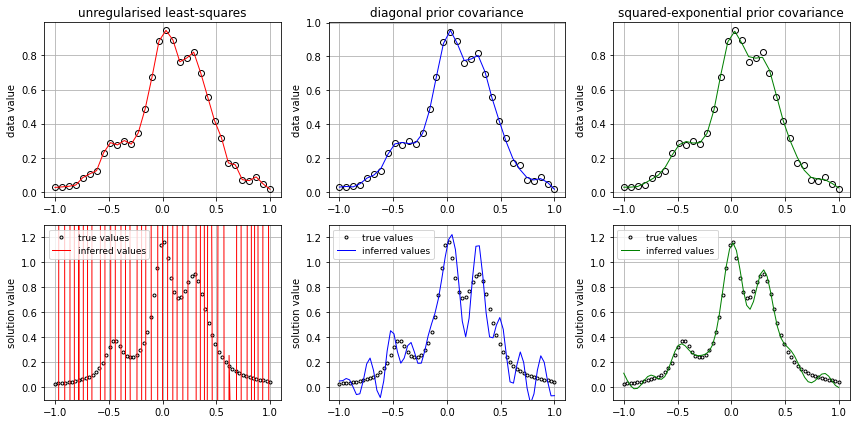

In [13]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(data_axis, y, "o", c='black', markerfacecolor='none')
ax1.plot(data_axis, A @ mu_lsqr, lw=1, c='red', label="solution prediction")
ax1.set_title("unregularised least-squares")
ax1.set_ylabel("data value")
ax1.grid()

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(data_axis, y, "o", c='black', markerfacecolor='none')
ax2.plot(data_axis, A @ mu_diag_prior, lw=1, c='blue')
ax2.set_title("diagonal prior covariance")
ax2.set_ylabel("data value")
ax2.grid()

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(data_axis, y, "o", c='black', markerfacecolor='none')
ax3.plot(data_axis, A @ mu_gp_prior, lw=1, c='green')
ax3.set_title("squared-exponential prior covariance")
ax3.set_ylabel("data value")
ax3.grid()

ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(x, solution, ".", c='black', markerfacecolor='none', label="true values")
ax4.plot(x, mu_lsqr, lw=1, c='red', label="inferred values")
ax4.set_ylim([-0.1, 1.3])
ax4.set_ylabel("solution value")
ax4.grid()
ax4.legend(loc=2, fontsize=9)

ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(x, solution, ".", c='black', markerfacecolor='none', label="true values")
ax5.plot(x, mu_diag_prior, lw=1, c='blue', label="inferred values")
ax5.set_ylim([-0.1, 1.3])
ax5.set_ylabel("solution value")
ax5.grid()
ax5.legend(loc=2, fontsize=9)

ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(x, solution, ".", c='black', markerfacecolor='none', label="true values")
ax6.plot(x, mu_gp_prior, lw=1, c='green', label="inferred values")
ax6.set_ylim([-0.1, 1.3])
ax6.set_ylabel("solution value")
ax6.grid()
ax6.legend(loc=2, fontsize=9)

plt.tight_layout()
plt.show()

Using the posterior covariance to calculate a standard-deviation for each solution value allows us to plot the uncertainty associated with our estimate:

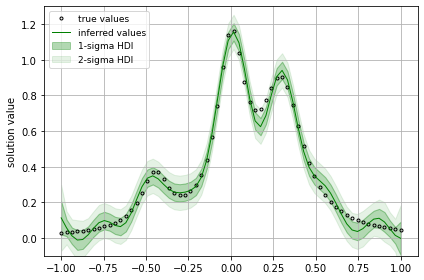

In [14]:
sig = sqrt(diagonal(cov_gp_prior))
plt.plot(x, solution, ".", c='black', markerfacecolor='none', label="true values")
plt.plot(x, mu_gp_prior, lw=1, c='green', label="inferred values")
plt.fill_between(x, mu_gp_prior - sig, mu_gp_prior + sig, color='green', alpha=0.3, label="1-sigma HDI")
plt.fill_between(x, mu_gp_prior + sig, mu_gp_prior + 2*sig, color='green', alpha=0.1, label="2-sigma HDI")
plt.fill_between(x, mu_gp_prior - 2*sig, mu_gp_prior - sig, color='green', alpha=0.1)
plt.ylim([-0.1, 1.3])
plt.ylabel("solution value")
plt.grid()
plt.legend(loc=2, fontsize=9)

plt.tight_layout()
plt.show()